In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.constraints import max_norm
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import special

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
R = k/n_channel

#Power splitting ratio
rho = 0.8
eps=1
eta=1
print('number of symbols:',M)



number of symbols: 16


In [4]:
def set_up_train_nn(P,EsNodB):
    label = np.random.randint(M,size=N)

    # creating one hot encoded vectors
    data = []
    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)

    # checking data shape
    data = np.array(data)
    print (data.shape)

    # checking generated data with it's label
    temp_check = [17,23,45,67,89,96,72,250,350]
    for i in temp_check:
        print(label[i],data[i])


    # Defined Autoencoder
    batch_size = 4096
    EbNo_train = 5.01187 #  coverted 7 db of EbNo

    # Transmitter Layers
    input_signal = Input(shape=(M,))
    encoded = Dense(M, activation='relu')(input_signal)
    encoded2 = Dense(2*n_channel, activation='linear')(encoded)

    # Normalize Power
    encoded3 = BatchNormalization(momentum=0,epsilon=1e-6,center=False,scale=False,axis=1)(encoded2)
    encoded3 = Lambda(lambda x: x*np.sqrt(P/2))(encoded3)

    #adding channel noise
    encoded4 = Lambda(lambda x: x+K.random_normal_variable((32768*2,2), 0,np.sqrt(0.5))[0:tf.shape(x)[0],:])(encoded3)


    # Slicing into CD and PD data, and applying noise

    cd_data = Lambda(lambda x: np.sqrt(rho)*np.sqrt(eps)*x)(encoded4)
    cd_data = Lambda(lambda x: x+K.random_normal_variable((32768*2,2), 0,np.sqrt(0.5))[0:tf.shape(x)[0],:])(cd_data)

    
    pd_data = Lambda(lambda x: K.expand_dims((1-rho)*eta*eps*K.sum(K.square(x),axis=1),axis=1))(encoded4)
    pd_data = Lambda(lambda x: x+K.random_normal_variable((32768*2,2), 0,np.sqrt(1))[0:tf.shape(x)[0],:])(pd_data)

    #combining the split data to feed the decoder
    data_split=[]
    data_split.append(cd_data)
    data_split.append(pd_data)

    data_split =  Concatenate(axis=1)(data_split)


    # Reciever Layer
    decoded = Dense(M, activation='relu')(data_split)
    decoded1 = Dense(M, activation='softmax')(decoded)
    autoencoder = Model(input_signal, decoded1)

    adam  =Adam(0.0075)
    sgd = SGD(lr=0.5)
    autoencoder.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy','mse'])

    # printing summary of layers and it's trainable parameters 
    print (autoencoder.summary())

    # traning auto encoder
    autoencoder.fit(data, data,
                    epochs=100,
                    batch_size=batch_size)

    # making encoder from full autoencoder
    encoder = Model(input_signal, encoded3)

    # for plotting learned consteallation diagram

    scatter_plot = []
    for i in range(0,M):
        temp = np.zeros(M)
        temp[i] = 1
        scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
    scatter_plot = np.array(scatter_plot)
    print (scatter_plot.shape)

    # ploting constellation diagram
    import matplotlib.pyplot as plt
    scatter_plot = scatter_plot.reshape(M,2,1)

    plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
    #plt.axis((-2,2,-2,2))
    plt.grid()
    #plt.title('Splitting Receiver: rho = '+str(rho)+' eps = '+str(eps))
    plt.xlabel('I Axis')
    plt.ylabel('Q Axis')
    plt.show()
    p_av = np.sum(np.square(scatter_plot),axis=1)
    print(sum(p_av)/16)

    return autoencoder

(16000, 16)
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
13 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
15 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)      

16000/16000 [==============================] - 0s 2us/step - loss: 0.6221 - acc: 0.7769 - mean_squared_error: 0.0201
Epoch 32/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.6143 - acc: 0.7785 - mean_squared_error: 0.0199
Epoch 33/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.5937 - acc: 0.7838 - mean_squared_error: 0.0193
Epoch 34/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.5894 - acc: 0.7900 - mean_squared_error: 0.0191
Epoch 35/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.5758 - acc: 0.7890 - mean_squared_error: 0.0187
Epoch 36/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.5734 - acc: 0.7898 - mean_squared_error: 0.0187
Epoch 37/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.5703 - acc: 0.7904 - mean_squared_error: 0.0187
Epoch 38/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.5685 - acc: 0.7941 - 

16000/16000 [==============================] - 0s 2us/step - loss: 0.4976 - acc: 0.8133 - mean_squared_error: 0.0165
Epoch 95/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.5000 - acc: 0.8179 - mean_squared_error: 0.0165
Epoch 96/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.4978 - acc: 0.8162 - mean_squared_error: 0.0165
Epoch 97/100
16000/16000 [==============================] - 0s 3us/step - loss: 0.5014 - acc: 0.8167 - mean_squared_error: 0.0165
Epoch 98/100
16000/16000 [==============================] - 0s 3us/step - loss: 0.4980 - acc: 0.8159 - mean_squared_error: 0.0164
Epoch 99/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.4962 - acc: 0.8148 - mean_squared_error: 0.0164
Epoch 100/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.5011 - acc: 0.8152 - mean_squared_error: 0.0165
(16, 1, 2)


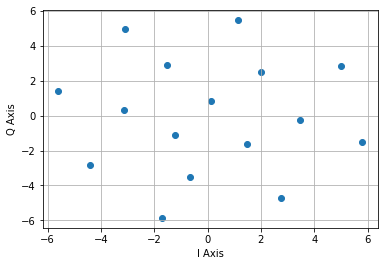

[20.40129]
Es/No: 10 SER: 0.211 Theor_SER_QAM: 0.22203085027243796 Theor_SER_PAM: 0.8038710393367886
(16000, 16)
8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
10 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
10 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_5 (Dense)      

16000/16000 [==============================] - 0s 3us/step - loss: 0.3714 - acc: 0.8779 - mean_squared_error: 0.0118
Epoch 36/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.3636 - acc: 0.8868 - mean_squared_error: 0.0114
Epoch 37/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.3605 - acc: 0.8852 - mean_squared_error: 0.0113
Epoch 38/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.3537 - acc: 0.8865 - mean_squared_error: 0.0112
Epoch 39/100
16000/16000 [==============================] - 0s 3us/step - loss: 0.3441 - acc: 0.8889 - mean_squared_error: 0.0109
Epoch 40/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.3459 - acc: 0.8871 - mean_squared_error: 0.0110
Epoch 41/100
16000/16000 [==============================] - 0s 3us/step - loss: 0.3392 - acc: 0.8871 - mean_squared_error: 0.0109
Epoch 42/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.3338 - acc: 0.8915 - 

16000/16000 [==============================] - 0s 3us/step - loss: 0.2314 - acc: 0.9189 - mean_squared_error: 0.0076
Epoch 99/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.2288 - acc: 0.9193 - mean_squared_error: 0.0076
Epoch 100/100
16000/16000 [==============================] - 0s 2us/step - loss: 0.2275 - acc: 0.9196 - mean_squared_error: 0.0076
(16, 1, 2)


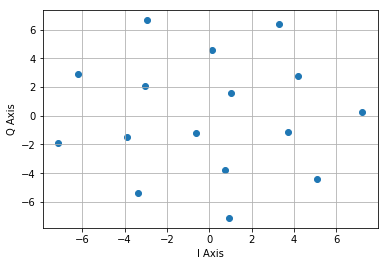

[31.77685]
Es/No: 12 SER: 0.0915 Theor_SER_QAM: 0.10935328833170666 Theor_SER_PAM: 0.7697963596067822
(17000, 16)
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
15 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
10 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
10 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
15 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_9 (Dense)   

17000/17000 [==============================] - 0s 2us/step - loss: 0.1547 - acc: 0.9552 - mean_squared_error: 0.0047
Epoch 36/100
17000/17000 [==============================] - 0s 2us/step - loss: 0.1522 - acc: 0.9567 - mean_squared_error: 0.0046
Epoch 37/100
17000/17000 [==============================] - 0s 2us/step - loss: 0.1514 - acc: 0.9545 - mean_squared_error: 0.0046
Epoch 38/100
17000/17000 [==============================] - 0s 3us/step - loss: 0.1469 - acc: 0.9561 - mean_squared_error: 0.0045
Epoch 39/100
17000/17000 [==============================] - 0s 2us/step - loss: 0.1476 - acc: 0.9557 - mean_squared_error: 0.0045
Epoch 40/100
17000/17000 [==============================] - 0s 2us/step - loss: 0.1417 - acc: 0.9579 - mean_squared_error: 0.0043
Epoch 41/100
17000/17000 [==============================] - 0s 3us/step - loss: 0.1348 - acc: 0.9594 - mean_squared_error: 0.0041
Epoch 42/100
17000/17000 [==============================] - 0s 2us/step - loss: 0.1367 - acc: 0.9579 - 

17000/17000 [==============================] - 0s 3us/step - loss: 0.0909 - acc: 0.9701 - mean_squared_error: 0.0029
Epoch 99/100
17000/17000 [==============================] - 0s 2us/step - loss: 0.0882 - acc: 0.9695 - mean_squared_error: 0.0029
Epoch 100/100
17000/17000 [==============================] - 0s 2us/step - loss: 0.0906 - acc: 0.9707 - mean_squared_error: 0.0029
(16, 1, 2)


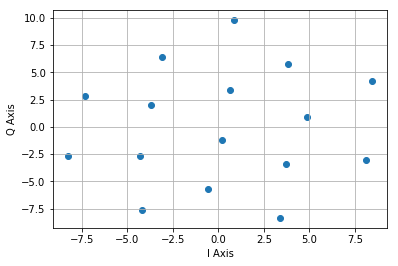

[49.477524]
Es/No: 14 SER: 0.015470588235294118 Theor_SER_QAM: 0.03715084560591553 Theor_SER_PAM: 0.7274140318971404
(24000, 16)
10 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
13 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
10 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
14 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
den

24000/24000 [==============================] - 0s 3us/step - loss: 0.0908 - acc: 0.9818 - mean_squared_error: 0.0023
Epoch 36/100
24000/24000 [==============================] - 0s 3us/step - loss: 0.0868 - acc: 0.9825 - mean_squared_error: 0.0022
Epoch 37/100
24000/24000 [==============================] - 0s 2us/step - loss: 0.0816 - acc: 0.9817 - mean_squared_error: 0.0021
Epoch 38/100
24000/24000 [==============================] - 0s 3us/step - loss: 0.0767 - acc: 0.9850 - mean_squared_error: 0.0019
Epoch 39/100
24000/24000 [==============================] - 0s 2us/step - loss: 0.0733 - acc: 0.9851 - mean_squared_error: 0.0018
Epoch 40/100
24000/24000 [==============================] - 0s 3us/step - loss: 0.0704 - acc: 0.9855 - mean_squared_error: 0.0018
Epoch 41/100
24000/24000 [==============================] - 0s 2us/step - loss: 0.0683 - acc: 0.9852 - mean_squared_error: 0.0017
Epoch 42/100
24000/24000 [==============================] - 0s 2us/step - loss: 0.0672 - acc: 0.9845 - 

24000/24000 [==============================] - 0s 3us/step - loss: 0.0250 - acc: 0.9937 - mean_squared_error: 6.7260e-04
Epoch 98/100
24000/24000 [==============================] - 0s 3us/step - loss: 0.0240 - acc: 0.9939 - mean_squared_error: 6.5037e-04
Epoch 99/100
24000/24000 [==============================] - 0s 2us/step - loss: 0.0245 - acc: 0.9937 - mean_squared_error: 6.8467e-04
Epoch 100/100
24000/24000 [==============================] - 0s 3us/step - loss: 0.0255 - acc: 0.9938 - mean_squared_error: 6.8783e-04
(16, 1, 2)


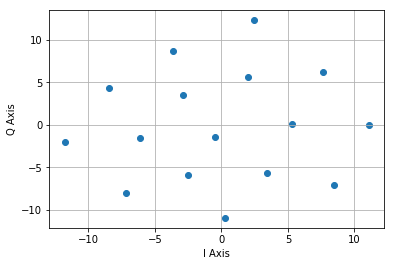

[79.32483]
Es/No: 16 SER: 0.00179 Theor_SER_QAM: 0.007152038493876245 Theor_SER_PAM: 0.6750695187632958


In [5]:
EsNodB_range = [10,12,14,16]
N_array = [16000,16000,17000,24000]
ser = [None]*len(EsNodB_range)
theor_ser_qam = [None]*len(EsNodB_range)
theor_ser_pam = [None]*len(EsNodB_range)

noise_std = np.sqrt(2)
for n in range(0,len(EsNodB_range)):
    
    EsNo=10.0**(EsNodB_range[n]/10.0)
    P = EsNo*(noise_std**2)
    
    no_errors = 0
    
    N=N_array[n]
   
    
    autoencoder = set_up_train_nn(P,EsNodB_range[n])
    
    # generating data for checking SER
    if EsNodB_range[n]>=16:
        N=100000
    test_label = np.random.randint(M,size=N)
    test_data = []

    for i in test_label:
        temp = np.zeros(M)
        temp[i] = 1
        test_data.append(temp)

    test_data = np.array(test_data)
    
    pred_final_signal = autoencoder.predict(test_data)
    
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ser[n] = no_errors / N 
    
    erfc_arg = np.sqrt(P)/(noise_std*np.sqrt(620))
    theor_ser_pam[n] = 15*special.erfc(erfc_arg)/16
    theor_ser_qam[n] = 1.5*special.erfc(np.sqrt(EsNo/10))
    
    P_sqrtM = 0.75*special.erfc(np.sqrt(EsNo/10))
    theor_ser_qam[n] = 1-(1-P_sqrtM)**2
    
    
    print ('Es/No:',EsNodB_range[n],'SER:',ser[n],'Theor_SER_QAM:',theor_ser_qam[n],'Theor_SER_PAM:',theor_ser_pam[n])
    

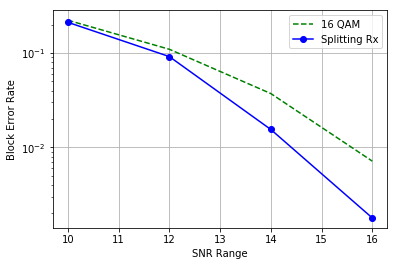

In [6]:
plt.plot(EsNodB_range, theor_ser_qam, 'g--',label='16 QAM')
#plt.plot(EsNodB_range, theor_ser_pam, 'k-',label='16 PAM')
plt.plot(EsNodB_range, ser, 'bo-',label='Splitting Rx')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()

In [7]:
ser

[0.211, 0.0915, 0.015470588235294118, 0.00179]